In [62]:
#Anshaj_Goyal
import pandas as pd
df = pd.read_csv('dataset_model.csv')
primaryKeyDf = pd.DataFrame()
for i in df:
  if df[i].is_unique:
    primaryKeyDf[i] = df[i]
    df = df.drop(i,axis=1)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [63]:
continuousColumns = [i for i in df._get_numeric_data().columns if(len(df[i].unique())>df.shape[0]/25)] #['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
categoricalColumns = [i for i in df if len(df[i].unique())<=df.shape[0]/25] #['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']
df.groupby('Loan_Status').count()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_Status,,,,,,,,,,,
N,187,192,186,192,183,192,192,181,186,179,192
Y,414,419,413,422,399,422,422,411,414,385,422


***Missing Value Check***

In [51]:
import numpy as np
for col in df.columns:
  missingPercent = np.mean(df[col].isnull())
  if round(missingPercent*100) >0:
    missingValues = df[col].isnull().sum().sum()
    print("Column {} with mean {} with missing values  {}".format(col,int(round(missingPercent*100)),missingValues))
#As the below output the following columns in data have missing values with number of missin values written

Column Gender with mean 2 with missing values  13
Column Dependents with mean 2 with missing values  15
Column Self_Employed with mean 5 with missing values  32
Column LoanAmount with mean 4 with missing values  22
Column Loan_Amount_Term with mean 2 with missing values  14
Column Credit_History with mean 8 with missing values  50


***Sparsity Check***

In [52]:
print(df.dtypes.apply(pd.api.types.is_sparse))
print("\n{} 0 Records Sparse".format(any(df.dtypes.apply(pd.api.types.is_sparse))))
#No Rows/Columns are sparse so we will carry on without removing any records 
#and handle missing data 

Gender               False
Married              False
Dependents           False
Education            False
Self_Employed        False
ApplicantIncome      False
CoapplicantIncome    False
LoanAmount           False
Loan_Amount_Term     False
Credit_History       False
Property_Area        False
Loan_Status          False
dtype: bool

False 0 Records Sparse


***Handle Missing Values***

In [64]:
#Replacing null values with the most frequent value in the respective column
for i in df.columns:
  df[i] = df[i].fillna(df[i].value_counts().nlargest(n=1).index[0])
df.isnull().sum()
# After Executing above segments of node no null values were found

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

***Outlier Detection & Handling***

In [65]:
df[continuousColumns].skew()
#Data is highly unsymmetrical so we'll skew it

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.745407
dtype: float64

In [56]:
#Except Credit_History every other column is having outliers
#Which is visible after looking the difference in 75% and max(100%) values

df[continuousColumns].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.465798
std,6109.041673,2926.248369,84.180967
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.250000
50%,3812.500000,1188.500000,125.000000
75%,5795.000000,2297.250000,164.750000
max,81000.000000,41667.000000,700.000000


In [66]:
#Will modify outlier values with conditions and won't remove it
#based on 0.05% quantile and 95% quantile
for i in continuousColumns:
  df[i] = np.where(df[i] <int(df[i].quantile(0.05)), int(df[i].quantile(0.1)),df[i])
  df[i] = np.where(df[i] >int(df[i].quantile(0.97)), int(df[i].quantile(0.9)),df[i])
df[continuousColumns].skew()
#So the skewed values of this df are now almost bearable
##Outlier Treatment Done

ApplicantIncome      1.776181
CoapplicantIncome    0.795976
LoanAmount           1.156346
dtype: float64

***Use Label Encoder as encoding technique on features , predict using below algorithms***

*1.Using Logistic Regression - Perform the parameter tuning and list your best performance metrics on -*Precision, Recall, F1 Score & AUROC

In [247]:
#Encoding the categorical features
#Adding those encoded feature columns in another dataframe
#Dropping original columns from the dataframe 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dfEnc = df.copy()
for i in categoricalColumns:
  print("{}  Feature Column Encoded".format(i.ljust(16," ")))
  dfEnc[i+"_enc"] = le.fit_transform(dfEnc[i])
  dfEnc = dfEnc.drop(i,axis=1)

Gender            Feature Column Encoded
Married           Feature Column Encoded
Dependents        Feature Column Encoded
Education         Feature Column Encoded
Self_Employed     Feature Column Encoded
Loan_Amount_Term  Feature Column Encoded
Credit_History    Feature Column Encoded
Property_Area     Feature Column Encoded
Loan_Status       Feature Column Encoded


In [249]:
#Class % Distribution of Target Variable
tdf = pd.DataFrame(le.fit_transform(df['Loan_Status']))
tdf.columns = (['Loan_Status'])
lb1, lb2 =  dfEnc['Loan_Status_enc'].value_counts()
print("1 Class %age - {}\n0 Class %age - {}".format((lb1*100)/(lb1+lb2), (lb2*100)/(lb1+lb2)))
dfEnc = dfEnc.drop('Loan_Status_enc',axis=1)
dfEnc.head()

1 Class %age - 68.72964169381108
0 Class %age - 31.270358306188925


,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_enc,Married_enc,Dependents_enc,Education_enc,Self_Employed_enc,Loan_Amount_Term_enc,Credit_History_enc,Property_Area_enc
0,5849,0.0,120.0,1,0,0,0,0,8,1,2
1,4583,1508.0,128.0,1,1,1,0,0,8,1,0
2,3000,0.0,66.0,1,1,0,0,1,8,1,2
3,2583,2358.0,120.0,1,1,0,1,0,8,1,2
4,6000,0.0,141.0,1,0,0,0,0,8,1,2


In [250]:
## Logistic Regression test_size 0.25 EncodingType - LabelEncoding
#Splitting of dataset into training and testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dfEnc,tdf,test_size = 0.25, \
                                                    random_state = 30, stratify = tdf)

print("Train Feature set: {}\nTrain Label Feature set: {}\nTest Feature set: {}\nTest label set: {}".format(\
len(x_train),len(y_train),len(x_test),len(y_test)))

Train Feature set: 460
Train Label Feature set: 460
Test Feature set: 154
Test label set: 154


In [251]:
#Stratify Analysis
lb1,lb0 = y_train['Loan_Status'].value_counts()
print("For Training Dataset\n1 Class %age - {}\n0 Class %age - {}\n".format((lb1*100)/(lb1+lb0),(lb0*100)/(lb1+lb0)))
lb1,lb0 = y_test['Loan_Status'].value_counts()
print("For Testing Dataset\n1 Class %age - {}\n0 Class %age - {}".format((lb1*100)/(lb1+lb0),(lb0*100)/(lb1+lb0)))

For Training Dataset
1 Class %age - 68.69565217391305
0 Class %age - 31.304347826086957

For Testing Dataset
1 Class %age - 68.83116883116882
0 Class %age - 31.16883116883117


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
model = LogisticRegression(random_state=30)
model.fit(x_train, y_train['Loan_Status'])
y_pred = model.predict(x_test)

Confusion Matrix 
 [[ 17  31]
 [  1 105]]
Accuracy of LR Model: 0.7922077922077922
Precision of LR Model: 0.7720588235294118
Recall of LR Model: 0.9905660377358491
F1 Score of LR Model: 0.8677685950413223
ROC_AUC score of LR Model: 0.6723663522012578


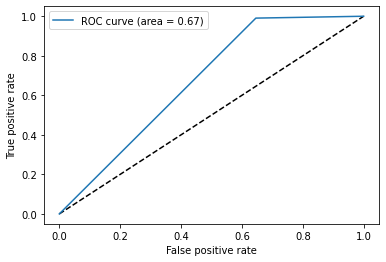

In [253]:
from matplotlib import pyplot as plt
print("Confusion Matrix \n %s" % confusion_matrix(y_test,y_pred))
print("Accuracy of LR Model: %s" % accuracy_score(y_test, y_pred))
print("Precision of LR Model: %s" % precision_score(y_test, y_pred))
print("Recall of LR Model: %s" % recall_score(y_test, y_pred))
print("F1 Score of LR Model: %s" % f1_score(y_test, y_pred))
print("ROC_AUC score of LR Model: %s" % roc_auc_score(y_test,y_pred))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% roc_auc_score(y_test,y_pred))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

***Parameters Tuning***

In [340]:
## Logistic Regression test_size 0.20 EncodingType - LabelEncoding
#Tuning Parameters
x_train, x_test, y_train, y_test = train_test_split(dfEnc,tdf,test_size = 0.20, \
                                                    random_state = 30, stratify = tdf)
model = LogisticRegression(random_state=30)
model.fit(x_train, y_train['Loan_Status'])
y_pred = model.predict(x_test)
print("Confusion Matrix \n %s" % confusion_matrix(y_test,y_pred))
print("Accuracy of LR Model: %s" % accuracy_score(y_test, y_pred))
print("Precision of LR Model: %s" % precision_score(y_test, y_pred))
print("Recall of LR Model: %s" % recall_score(y_test, y_pred))
print("F1 Score of LR Model: %s" % f1_score(y_test, y_pred))
print("ROC_AUC score of LR Model: %s" % roc_auc_score(y_test,y_pred))

#The best performance was when the test size of dataset was 0.20 in comparision to test_size of 0.25

Confusion Matrix 
 [[14 24]
 [ 1 84]]
Accuracy of LR Model: 0.7967479674796748
Precision of LR Model: 0.7777777777777778
Recall of LR Model: 0.9882352941176471
F1 Score of LR Model: 0.8704663212435234
ROC_AUC score of LR Model: 0.678328173374613


***2.Using RandomForest Classifier - Perform the parameter tuning and list your best performance metrics on***

*Precision ,Recall & F1 Score ,AUROC*

In [334]:
## RandomForestClassifier test_size 0.25 EncodingType - LabelEncoding
from sklearn.ensemble import RandomForestClassifier
x_train, x_test, y_train, y_test = train_test_split(dfEnc,tdf,test_size = 0.25, \
                                                    random_state = 30, stratify = tdf)
model = RandomForestClassifier(random_state=30)
model.fit(x_train,y_train['Loan_Status'])
y_pred = model.predict(x_test)
print("Confusion Matrix \n %s" % confusion_matrix(y_test,y_pred))
print("Accuracy of RF Model: %s" % accuracy_score(y_test, y_pred))
print("Precision of RF Model: %s" % precision_score(y_test, y_pred))
print("Recall of RF Model: %s" % recall_score(y_test, y_pred))
print("F1 Score of RF Model: %s" % f1_score(y_test, y_pred))
print("ROC_AUC score of RF Model: %s" % roc_auc_score(y_test,y_pred))



Confusion Matrix 
 [[20 28]
 [ 8 98]]
Accuracy of RF Model: 0.7662337662337663
Precision of RF Model: 0.7777777777777778
Recall of RF Model: 0.9245283018867925
F1 Score of RF Model: 0.8448275862068966
ROC_AUC score of RF Model: 0.6705974842767295


In [342]:
## RandomForestClassifier test_size 0.20 EncodingType - LabelEncoding
x_train, x_test, y_train, y_test = train_test_split(dfEnc,tdf,test_size = 0.20, \
                                                    random_state = 30, stratify = tdf)
model = RandomForestClassifier(random_state=30)
model.fit(x_train,y_train['Loan_Status'])
y_pred = model.predict(x_test)
print("Confusion Matrix \n %s" % confusion_matrix(y_test,y_pred))
print("Accuracy of RF Model: %s" % accuracy_score(y_test, y_pred))
print("Precision of RF Model: %s" % precision_score(y_test, y_pred))
print("Recall of RF Model: %s" % recall_score(y_test, y_pred))
print("F1 Score of RF Model: %s" % f1_score(y_test, y_pred))
print("ROC_AUC score of RF Model: %s" % roc_auc_score(y_test,y_pred))

#The performance improved when the dataset test_size was improved to 0.27 from 0.25

Confusion Matrix 
 [[17 21]
 [ 8 77]]
Accuracy of RF Model: 0.7642276422764228
Precision of RF Model: 0.7857142857142857
Recall of RF Model: 0.9058823529411765
F1 Score of RF Model: 0.8415300546448088
ROC_AUC score of RF Model: 0.676625386996904




*Use One hot Encoder as encoding technique on feature , predict using the below algorithms*

***3.Using Logistic Regression - Perform the parameter tuning and list your best performance metrics on -***

*Precision ,Recall & F1 Score ,AUROC*

In [322]:
#oneHotEncoding the features and labelHotEncoding the target variable
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
dfHotEnc = df.copy()

tdf = pd.DataFrame(le.fit_transform(df['Loan_Status']))
tdf.columns = (['Loan_Status'])

for i in set(categoricalColumns)-set(['Loan_Status']):
  enc_rel = pd.DataFrame(ohe.fit_transform(dfHotEnc[[i]]).toarray())
  enc_rel = enc_rel.add_prefix(i+"_")
  dfHotEnc = dfHotEnc.join(enc_rel)
  dfHotEnc = dfHotEnc.drop(i,axis=1)

dfHotEnc = dfHotEnc.drop('Loan_Status',axis=1)  
dfHotEnc.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_0,Gender_1,Loan_Amount_Term_0,Loan_Amount_Term_1,Loan_Amount_Term_2,Loan_Amount_Term_3,Loan_Amount_Term_4,Loan_Amount_Term_5,Loan_Amount_Term_6,Loan_Amount_Term_7,Loan_Amount_Term_8,Loan_Amount_Term_9,Education_0,Education_1,Dependents_0,Dependents_1,Dependents_2,Dependents_3,Married_0,Married_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Property_Area_2,Self_Employed_0,Self_Employed_1
0,5849,0.0,120.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,4583,1508.0,128.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,3000,0.0,66.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,2583,2358.0,120.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,6000,0.0,141.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [336]:
## Logistic Regression test_size 0.25 EncodingType - OneHotEncoding
x_train, x_test, y_train, y_test = train_test_split(dfHotEnc,tdf,test_size = 0.25, \
                                                    random_state = 30, stratify = tdf)
model = LogisticRegression(random_state=30)
model.fit(x_train, y_train['Loan_Status'])
y_pred = model.predict(x_test)
print("Confusion Matrix \n %s" % confusion_matrix(y_test,y_pred))
print("Accuracy of LR Model: %s" % accuracy_score(y_test, y_pred))
print("Precision of LR Model: %s" % precision_score(y_test, y_pred))
print("Recall of LR Model: %s" % recall_score(y_test, y_pred))
print("F1 Score of LR Model: %s" % f1_score(y_test, y_pred))
print("ROC_AUC score of LR Model: %s" % roc_auc_score(y_test,y_pred))


Confusion Matrix 
 [[ 17  31]
 [  1 105]]
Accuracy of LR Model: 0.7922077922077922
Precision of LR Model: 0.7720588235294118
Recall of LR Model: 0.9905660377358491
F1 Score of LR Model: 0.8677685950413223
ROC_AUC score of LR Model: 0.6723663522012578


In [341]:
## Logistic Regression test_size 0.27 EncodingType - OneHotEncoding
x_train, x_test, y_train, y_test = train_test_split(dfHotEnc,tdf,test_size = 0.27, \
                                                    random_state = 30, stratify = tdf)
model = LogisticRegression(random_state=30)
model.fit(x_train, y_train['Loan_Status'])
y_pred = model.predict(x_test)
print("Confusion Matrix \n %s" % confusion_matrix(y_test,y_pred))
print("Accuracy of LR Model: %s" % accuracy_score(y_test, y_pred))
print("Precision of LR Model: %s" % precision_score(y_test, y_pred))
print("Recall of LR Model: %s" % recall_score(y_test, y_pred))
print("F1 Score of LR Model: %s" % f1_score(y_test, y_pred))
print("ROC_AUC score of LR Model: %s" % roc_auc_score(y_test,y_pred))


Confusion Matrix 
 [[ 19  33]
 [  1 113]]
Accuracy of LR Model: 0.7951807228915663
Precision of LR Model: 0.773972602739726
Recall of LR Model: 0.9912280701754386
F1 Score of LR Model: 0.8692307692307693
ROC_AUC score of LR Model: 0.678306342780027


***4.Using RandomForest Classifier - Perform the parameter tuning and list your best performance metrics on -***

*Precision ,Recall & F1 Score ,AUROC*

In [338]:
## RandomForestClassifier test_size 0.25 EncodingType - OneHotEncoding
x_train, x_test, y_train, y_test = train_test_split(dfEnc,tdf,test_size = 0.25, \
                                                    random_state = 30, stratify = tdf)
model = RandomForestClassifier(random_state=30)
model.fit(x_train,y_train['Loan_Status'])
y_pred = model.predict(x_test)
print("Confusion Matrix \n %s" % confusion_matrix(y_test,y_pred))
print("Accuracy of RF Model: %s" % accuracy_score(y_test, y_pred))
print("Precision of RF Model: %s" % precision_score(y_test, y_pred))
print("Recall of RF Model: %s" % recall_score(y_test, y_pred))
print("F1 Score of RF Model: %s" % f1_score(y_test, y_pred))
print("ROC_AUC score of RF Model: %s" % roc_auc_score(y_test,y_pred))

Confusion Matrix 
 [[20 28]
 [ 8 98]]
Accuracy of RF Model: 0.7662337662337663
Precision of RF Model: 0.7777777777777778
Recall of RF Model: 0.9245283018867925
F1 Score of RF Model: 0.8448275862068966
ROC_AUC score of RF Model: 0.6705974842767295


In [339]:
## RandomForestClassifier test_size 0.27 EncodingType - OneHotEncoding
x_train, x_test, y_train, y_test = train_test_split(dfEnc,tdf,test_size = 0.27, \
                                                    random_state = 30, stratify = tdf)
model = RandomForestClassifier(random_state=30)
model.fit(x_train,y_train['Loan_Status'])
y_pred = model.predict(x_test)
print("Confusion Matrix \n %s" % confusion_matrix(y_test,y_pred))
print("Accuracy of RF Model: %s" % accuracy_score(y_test, y_pred))
print("Precision of RF Model: %s" % precision_score(y_test, y_pred))
print("Recall of RF Model: %s" % recall_score(y_test, y_pred))
print("F1 Score of RF Model: %s" % f1_score(y_test, y_pred))
print("ROC_AUC score of RF Model: %s" % roc_auc_score(y_test,y_pred))

Confusion Matrix 
 [[ 22  30]
 [  7 107]]
Accuracy of RF Model: 0.7771084337349398
Precision of RF Model: 0.781021897810219
Recall of RF Model: 0.9385964912280702
F1 Score of RF Model: 0.852589641434263
ROC_AUC score of RF Model: 0.6808367071524967


In Logistic Regression:

    In OneHotEncoding:
    Performance Increased On Increasing test_size 0.25 -> 0.27

    In Lab Encoding:
    Performance Increased on Decreasing test_size 0.25 -> 0.20

    So the best was OneHotEncoding here as the training data
    it took was less and still gave better peroformance

In RandomForestClassifier:

    In Label Encoding :

    Performance Decreased when test_size of dataset 
    was decreased from 0.25 -> 0.20

    In OneHotEncoding:

    Performance Increased when test_size of dataset
    was increased from 0.25 -> 0.27 

    So Random Classifier was best in OneHotEncoding for the same 
    reason i.e., increased dataset test_size and still accuracy
    was improved 